In [1]:
import sys
from typing import cast

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
from matplotlib.animation import FuncAnimation
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

sys.path.append("..")

from graph import get_ba, get_er, get_rr
from graph.utils import get_edge_list
from heat.plot import plot, plot_graph, plot_image
from heat.simulation import argument
from heat.simulation.solve import solve
from heat.simulation.solve_exact import solve as solve_exact
from neural_rk.path import FIG_DIR

In [2]:
args = argument.get_args(
    [
        "--num_nodes", "20",
        "--hot_ratio", "0.5",
        "--dissipation", "0.5",
        "--seed", "0",
    ]
)

In [3]:
rng = np.random.default_rng(args.seed)

# Graph setting
network_type = argument.get_network_type(args.network_type, rng)
num_nodes = argument.get_num_nodes(args.num_nodes, rng)
mean_degree = argument.get_mean_degree(args.mean_degree, rng)

if network_type == "er":
    graph = get_er(num_nodes, mean_degree, rng=rng)
elif network_type == "ba":
    graph = get_ba(num_nodes, mean_degree, rng=rng)
else:
    graph = get_rr(num_nodes, mean_degree, rng=rng)

# Since only gcc is selected, the graph can have smaller num_nodes
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()
edge_list = get_edge_list(graph)


dts = argument.get_dt(
    args.max_time, args.steps, args.dt_delta, tuple(args.dt_clip), rng
)
time = np.insert(np.cumsum(dts), 0, 0.0)

dissipation = argument.get_dissipation(num_edges, args.dissipation, rng)
initial_temperature = argument.get_initial_condition(num_nodes, args.hot_ratio, rng)

In [4]:
temperatures = solve(args.solver, graph, dissipation, initial_temperature, dts)

# Plot

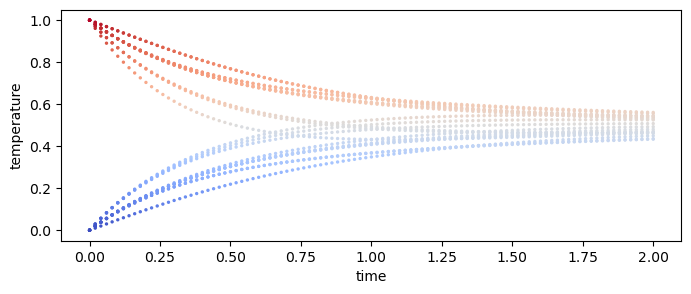

In [5]:
fig, ax = plt.subplots(figsize=(8, 3))
plot(ax, temperatures, time)

ax.set_xlabel("time")
ax.set_ylabel("temperature")

fig.show()

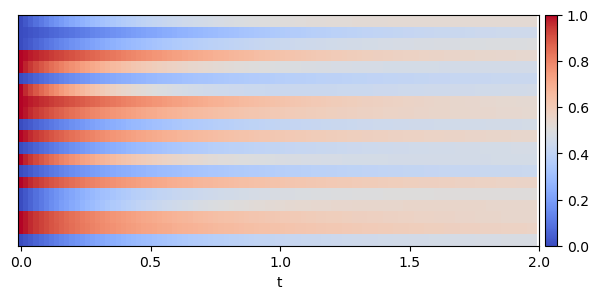

In [6]:
fig, ax = plt.subplots(figsize=(8, 3))

xticks = np.round(np.linspace(0.0, time[-1], 5), 2)
im = plot_image(ax, temperatures, xticks=xticks)
fig.colorbar(im, ax=ax, location="right", pad=0.01)
ax.set_xlabel("t")

fig.show()

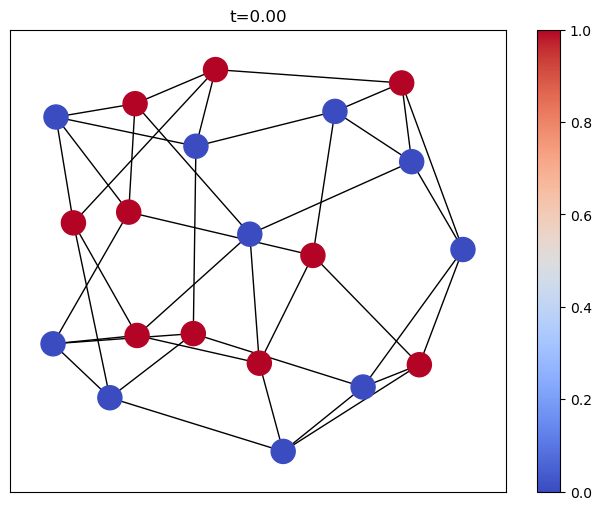

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

pos = cast(dict[int, npt.NDArray[np.float32]], nx.spring_layout(graph))

plot_graph(ax, graph, pos, temperatures[0])
fig.colorbar(
    ScalarMappable(cmap="coolwarm", norm=Normalize(vmin=0.0, vmax=1.0)),
    ax=ax,
)

def update(frame: int) -> None:
    ax.clear()
    plot_graph(ax, graph, pos, temperatures[frame])
    ax.set_title(f"t={time[frame]:.2f}")

anim = FuncAnimation(fig, update, frames=len(time), interval=50)
anim.save(str(FIG_DIR / "heat_example.gif"))